In [1]:
import numpy as np
import pandas as pd
import polars as pl
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [2]:
v = 45
n = 100
config = 'local'

if config == 'local':
    i_rdf = 60
    i_cbf = 60
    i_sf = 60
    i_pf = 60
    p = 45
    q = 130

if config == 'global':
    i_rdf = 120
    i_cbf = 120
    i_sf = 120
    i_pf = 60
    p = 50
    q = 200

num_runs = 60

In [3]:
def get_num_possible_receivers(row, positions): 
    x0 = row[8] # pos_x
    y0 = row[9] # pos_y
    ts = row[0] # timestamp
    return len(positions.filter((pl.col('timestamp') == ts) & (((pl.col('pos_x') -x0)**2 + (pl.col('pos_y') -y0)**2) <= 509.8**2)))
    # positions_now = positions.filter(pl.col('timestamp') == ts)
    # dist = np.sqrt(np.power(positions_now['pos_x'] -x0, 2) + np.power(positions_now['pos_y'] -y0, 2))
    # valid_positions = dist[dist <= 509.8]
    # print(row['num_receivers'] / (len(valid_positions) -1) ,len(positions), len(positions_now), row['num_receivers'], len(valid_positions) -1, row['seqNo'])
    #'return len(valid_positions)

In [4]:
def get_reception_rate(events, positions):
    event_times = events['timestamp'].unique()
    positions = positions.groupby('nodeId').apply(lambda group: pl.concat([group, pl.DataFrame(event_times)], how="diagonal").sort('timestamp').interpolate())
    positions = positions.filter(~pl.col('pos_x').is_null() & pl.col('timestamp').is_in(event_times))
    events = events.join(positions, how='inner', on=['nodeId','timestamp'])
    sent_events = events.filter(pl.col('eventType') == "PktSent")
    received_events = events.filter((pl.col('eventType') == "PktRcvd") & (pl.col('numHops') == 0))
    received_count = received_events.groupby('seqNo').agg(pl.count().alias("num_receivers"))
    sent_events = sent_events.join(received_count, how='inner', on='seqNo')
    sent_events = events.filter(pl.col('eventType') == "PktSent")
    received_events = events.filter((pl.col('eventType') == "PktRcvd") & (pl.col('numHops') == 0))
    received_count = received_events.groupby('seqNo').agg(pl.count().alias("num_receivers"))
    sent_events = sent_events.join(received_count, how='inner', on='seqNo')
    positions_at_sent_time= positions.filter(pl.col('timestamp').is_in(sent_events['timestamp'].unique()))
    enhanced_sent_events = pl.concat([sent_events, positions_at_sent_time.with_columns(pl.lit('position').alias('eventType'))], how='diagonal').sort(['timestamp','eventType'], reverse=True)
    enhanced_sent_events = enhanced_sent_events.groupby('timestamp').agg([
        (pl.col('eventType') == 'position').sum().alias('posEvents'),
        (pl.col('eventType') == 'PktSent').sum().alias('sentEvent'),
        pl.col("num_receivers").last(),
        pl.col('pos_x').last().alias('pos_x'),
        pl.col('pos_y').last().alias('pos_y'),
        (pl.Expr.pow(pl.col('pos_x') - pl.col('pos_x').last(), 2) + pl.Expr.pow(pl.col('pos_y') - pl.col('pos_y').last(), 2) <= pl.lit(509.8 **2)).sum().alias('num_possible_receivers')
    ])
    reception_rates = enhanced_sent_events.select([(pl.col('num_receivers') / (pl.col('num_possible_receivers')-1)).alias('pdr')])
    reception_rates = np.array(reception_rates)[0]
    pos_x = np.array(enhanced_sent_events['pos_x'])
    pos_y = np.array(enhanced_sent_events['pos_y'])

    return (reception_rates, pos_x, pos_y)

In [5]:
reception_rates_cbf = np.array([])
pos_x_cbf = np.array([])
pos_y_cbf = np.array([])

for r in range(num_runs):
    events = pl.read_csv(f'../res/v{v}/rdf_n{n}_i{i_cbf}_q0_r{r}.csv')
    positions = pl.read_csv(f'../res/v{v}/course_rdf_n{n}_i{i_cbf}_q0_r{r}.csv', dtypes = [pl.Float64, pl.Int64, pl.Float32, pl.Float32, pl.Float32])
    (reception_rates, pos_x, pos_y) = get_reception_rate(events, positions)
    reception_rates_cbf = np.concatenate((reception_rates_cbf, reception_rates))
    pos_x_cbf = np.concatenate((pos_x_cbf, pos_x))
    pos_y_cbf = np.concatenate((pos_y_cbf, pos_y))

In [6]:
reception_rates_rdf = np.array([])
pos_x_rdf = np.array([])
pos_y_rdf = np.array([])

for r in range(num_runs):
    events = pl.read_csv(f'../res/v{v}/rdf_n{n}_i{i_rdf}_q{q}_r{r}.csv')
    positions = pl.read_csv(f'../res/v{v}/course_rdf_n{n}_i{i_rdf}_q{q}_r{r}.csv', dtypes = [pl.Float64, pl.Int64, pl.Float32, pl.Float32, pl.Float32])
    (reception_rates, pos_x, pos_y) = get_reception_rate(events, positions)
    reception_rates_rdf = np.concatenate((reception_rates_rdf, reception_rates))
    pos_x_rdf = np.concatenate((pos_x_rdf, pos_x))
    pos_y_rdf = np.concatenate((pos_y_rdf, pos_y))

In [7]:
reception_rates_sf = np.array([])
pos_x_sf = np.array([])
pos_y_sf = np.array([])

for r in range(num_runs):
    events = pl.read_csv(f'../res/v{v}/sf_n{n}_i{i_sf}_p{p}_r{r}.csv')
    positions = pl.read_csv(f'../res/v{v}/course_sf_n{n}_i{i_sf}_p{p}_r{r}.csv', dtypes = [pl.Float64, pl.Int64, pl.Float32, pl.Float32, pl.Float32])
    (reception_rates, pos_x, pos_y) = get_reception_rate(events, positions)
    reception_rates_sf = np.concatenate((reception_rates_sf, reception_rates))
    pos_x_sf = np.concatenate((pos_x_sf, pos_x))
    pos_y_sf = np.concatenate((pos_y_sf, pos_y))

In [8]:
reception_rates_pf = np.array([])
pos_x_pf = np.array([])
pos_y_pf = np.array([])

for r in range(num_runs):
    events = pl.read_csv(f'../res/v{v}/sf_n{n}_i{i_pf}_p100_r{r}.csv')
    positions = pl.read_csv(f'../res/v{v}/course_sf_n{n}_i{i_pf}_p100_r{r}.csv', dtypes = [pl.Float64, pl.Int64, pl.Float32, pl.Float32, pl.Float32])
    (reception_rates, pos_x, pos_y) = get_reception_rate(events, positions)
    reception_rates_pf = np.concatenate((reception_rates_pf, reception_rates))
    pos_x_pf = np.concatenate((pos_x_pf, pos_x))
    pos_y_pf = np.concatenate((pos_y_pf, pos_y))

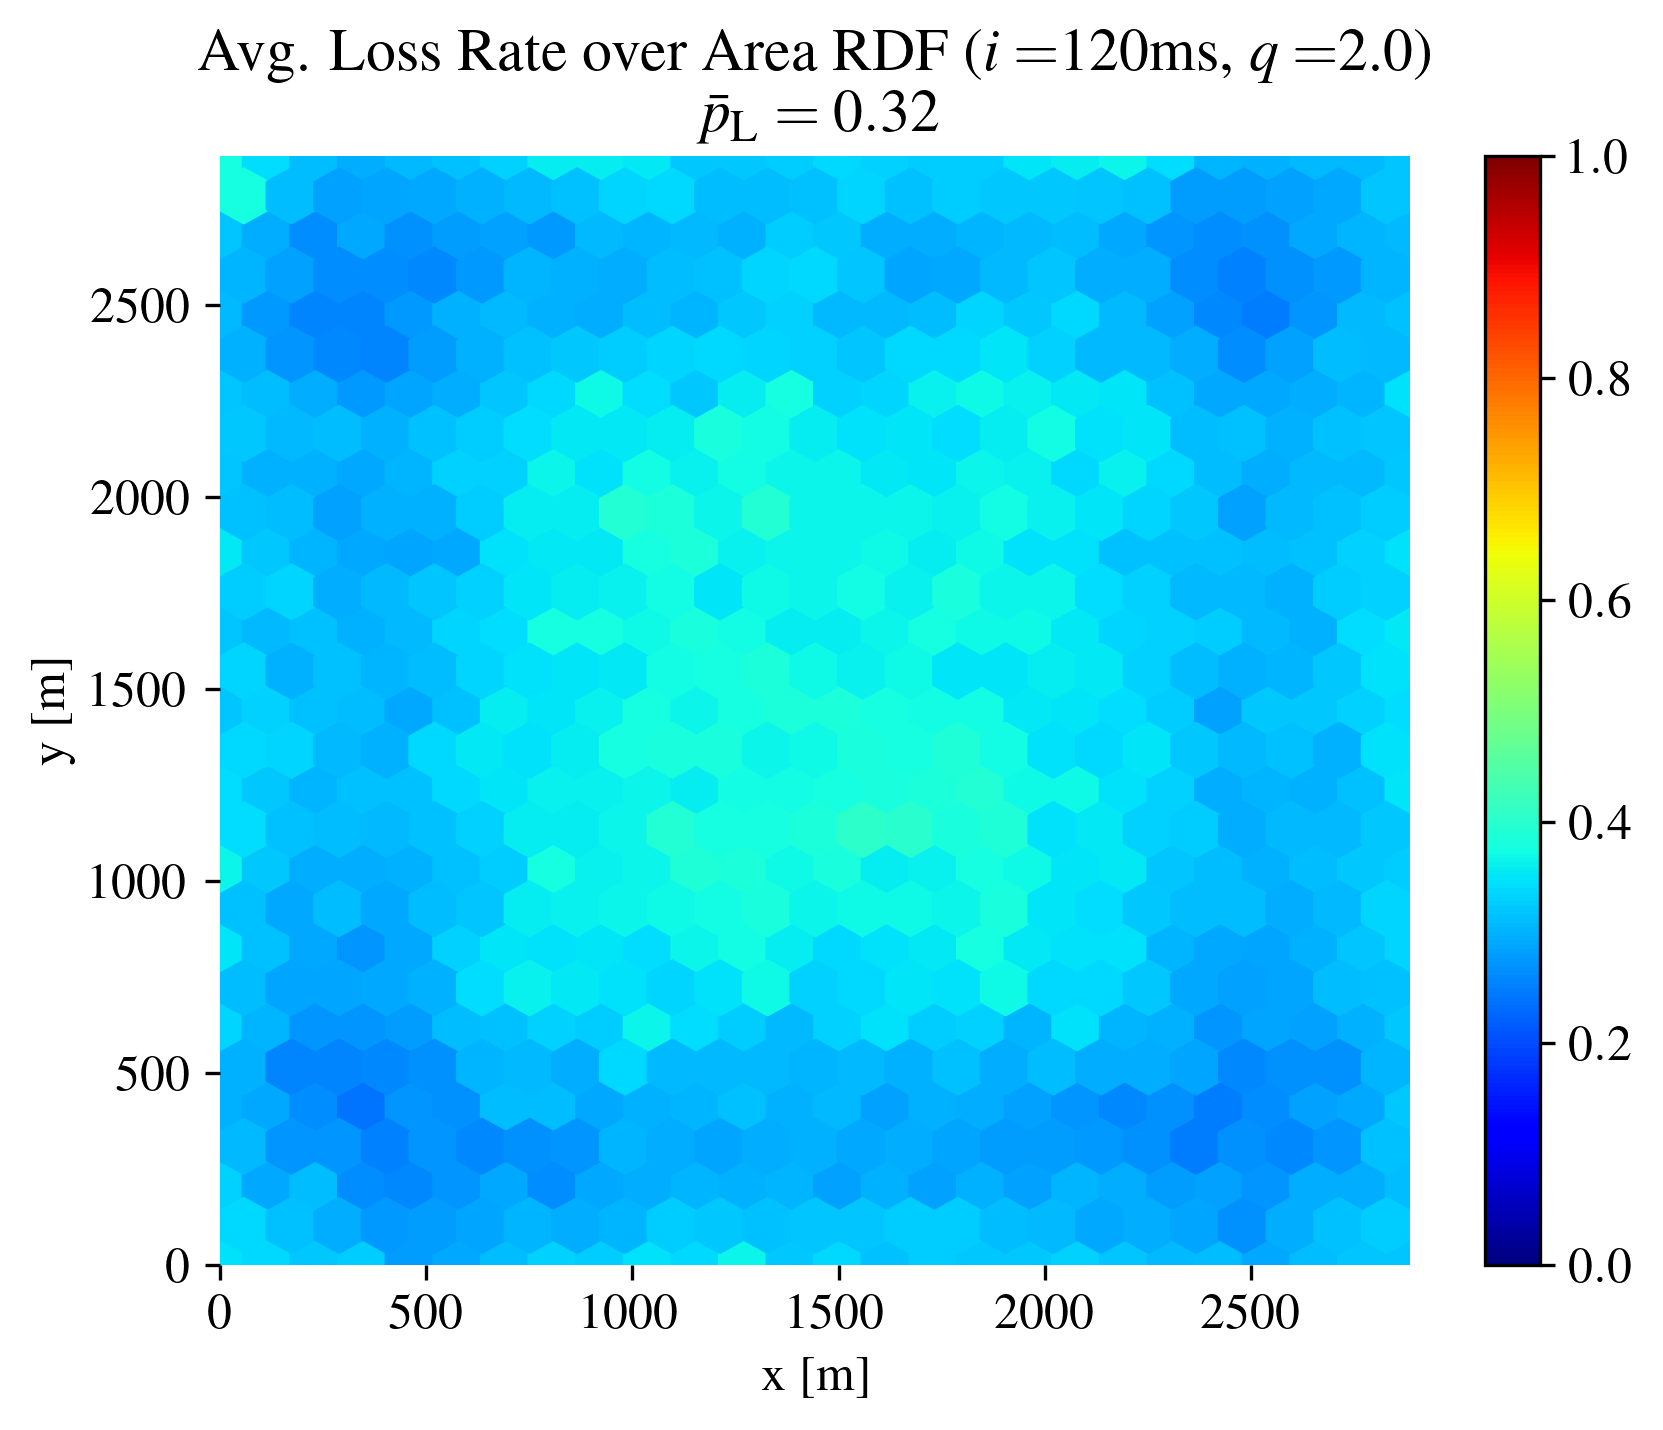

In [9]:
## RDF
size = math.sqrt(n / 12) * 1000
fig, ax = plt.subplots()
im = ax.hexbin(
    pos_x_rdf, 
    pos_y_rdf, 
    C=1-reception_rates_rdf, 
    vmin=0,
    vmax=1,
    gridsize=25,
    clip_on=True,
    cmap=cm.jet
)

#ax.axis(False)
ax.set_ylim([0,size])
ax.set_xlim([0,size])
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title(f'Avg. Loss Rate over Area RDF ($i=${i_rdf}ms, $q=${q/100}) \n$\\bar{{p}}_\\mathrm{{L}} = {1-np.mean(reception_rates_rdf):.2f}$')
plt.colorbar(im)

fig.savefig(f"../figures/loss_rate_area_{config}_rdf_n{n}_q{q}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_area_{config}_rdf_n{n}_q{q}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()

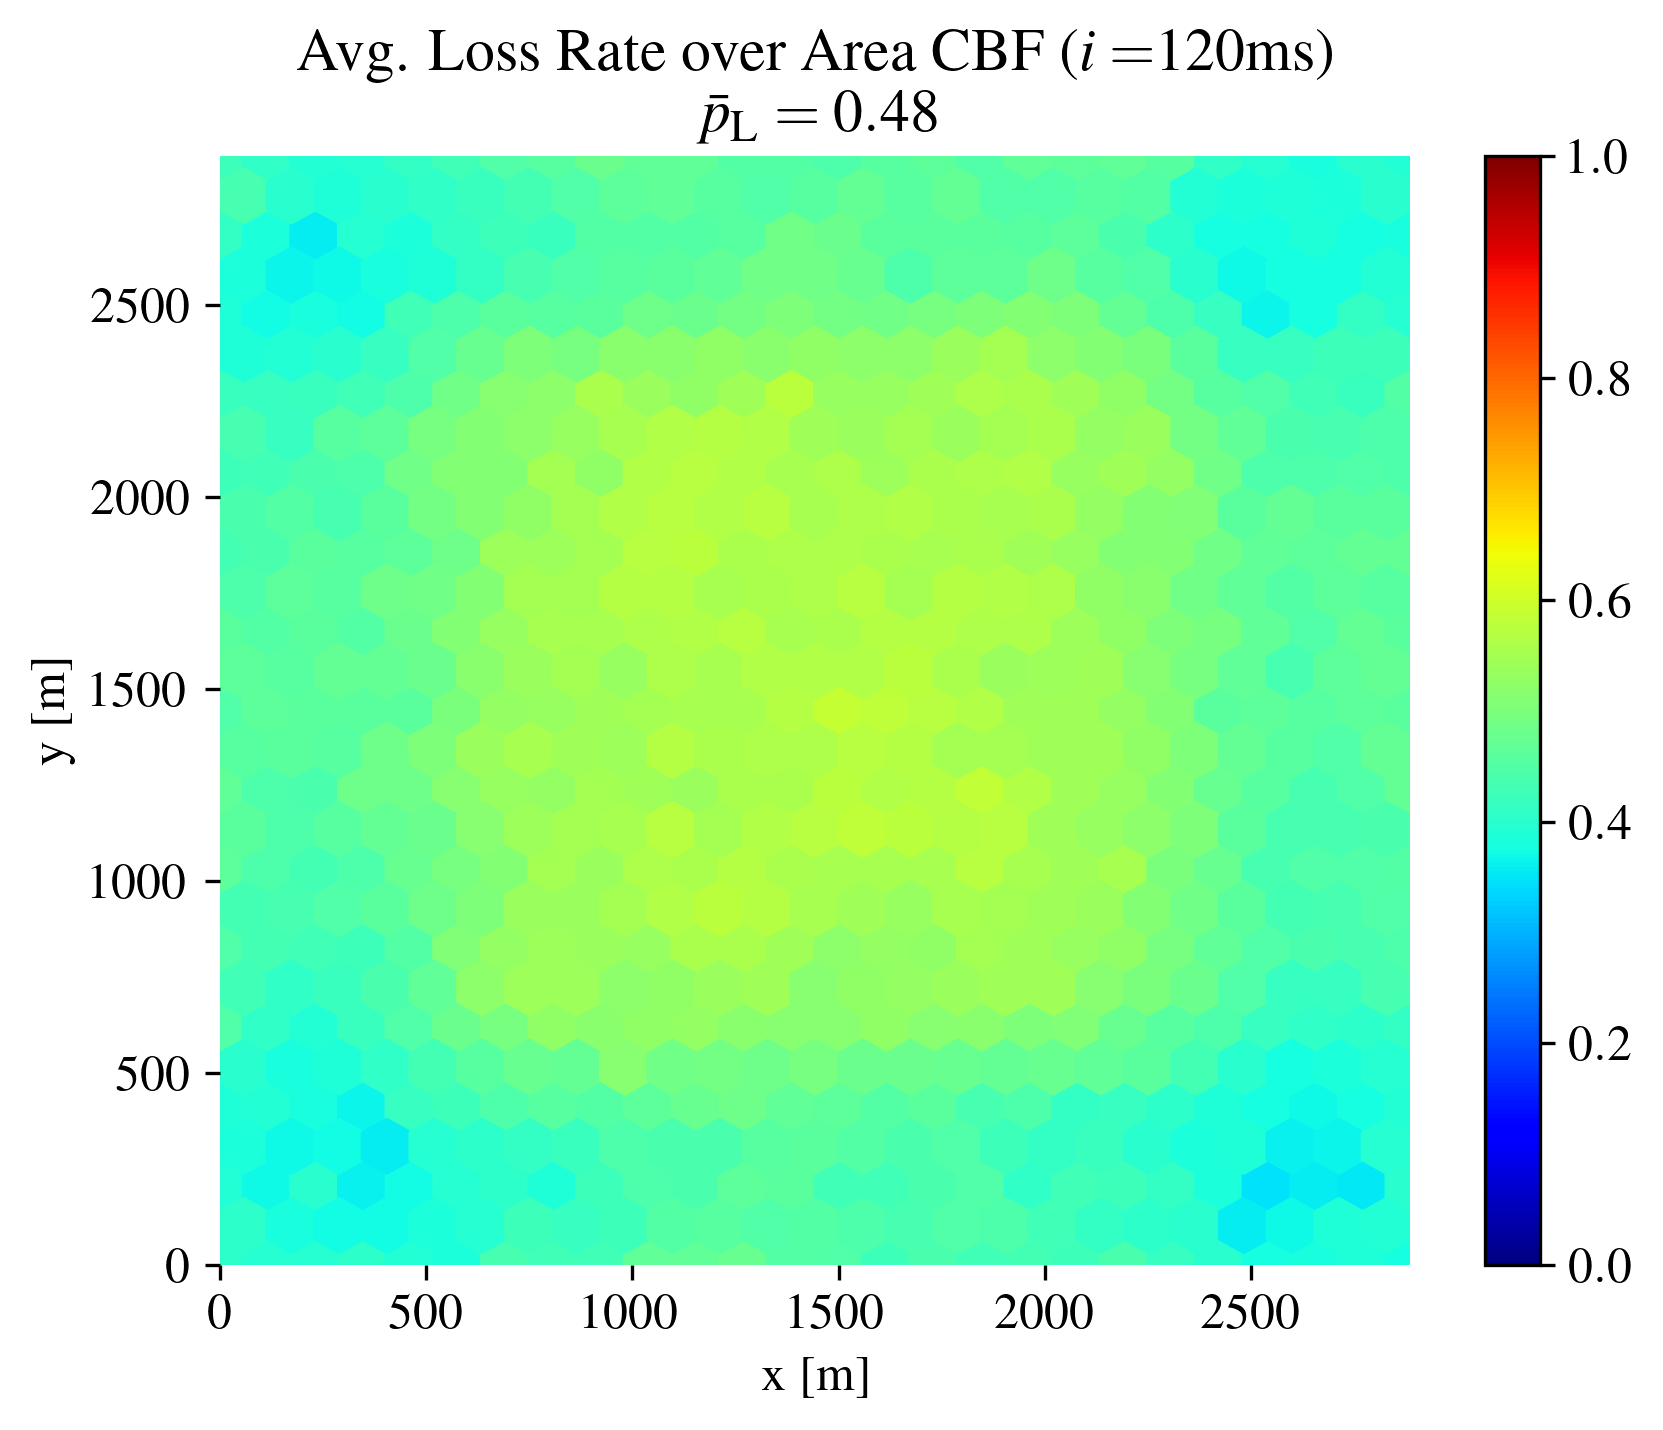

In [10]:
# CBF
size = math.sqrt(n / 12) * 1000
fig, ax = plt.subplots()
im = ax.hexbin(
    pos_x_cbf, 
    pos_y_cbf, 
    C=1-reception_rates_cbf, 
    vmin=0,
    vmax=1,
    gridsize=25,
    clip_on=True,
    cmap=cm.jet
)

ax.set_ylim([0,size])
ax.set_xlim([0,size])
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title(f'Avg. Loss Rate over Area CBF ($i=${i_cbf}ms) \n$\\bar{{p}}_\\mathrm{{L}} = {1-np.mean(reception_rates_cbf):.2f}$')
plt.colorbar(im)

fig.savefig(f"../figures/loss_rate_area_{config}_cbf_n{n}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_area_{config}_cbf_n{n}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()

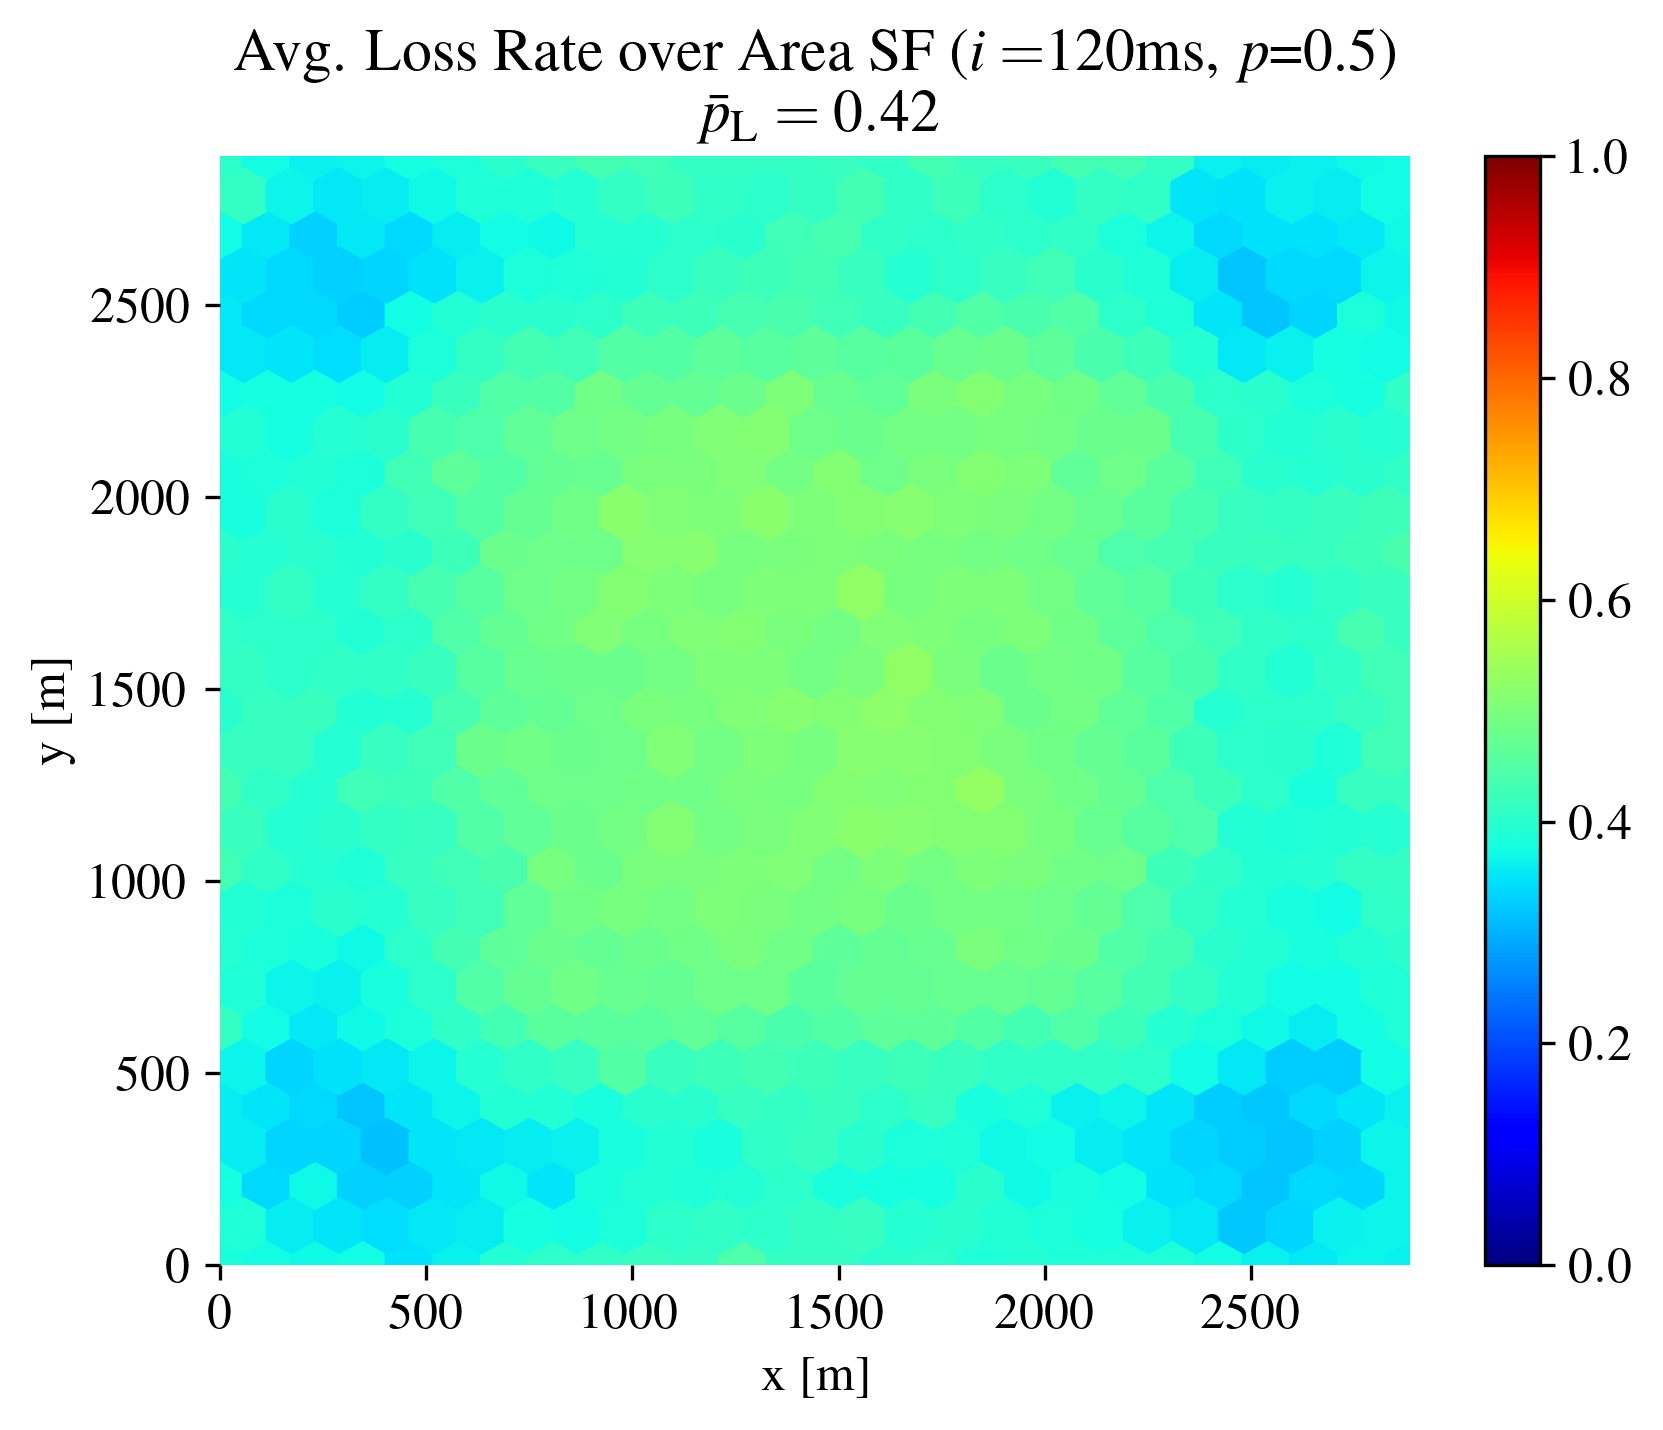

In [11]:
## SF
size = math.sqrt(n / 12) * 1000
fig, ax = plt.subplots()
im = ax.hexbin(
    pos_x_sf, 
    pos_y_sf, 
    C=1-reception_rates_sf, 
    vmin=0,
    vmax=1,
    gridsize=25,
    clip_on=True,
    cmap=cm.jet
)

#ax.axis(False)
ax.set_ylim([0,size])
ax.set_xlim([0,size])
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title(f'Avg. Loss Rate over Area SF ($i=${i_sf}ms, $p$={p/100}) \n$\\bar{{p}}_\\mathrm{{L}} = {1-np.mean(reception_rates_sf):.2f}$')
plt.colorbar(im)

fig.savefig(f"../figures/loss_rate_area_{config}_sf_n{n}_p{p}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_area_{config}_sf_n{n}_p{p}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()

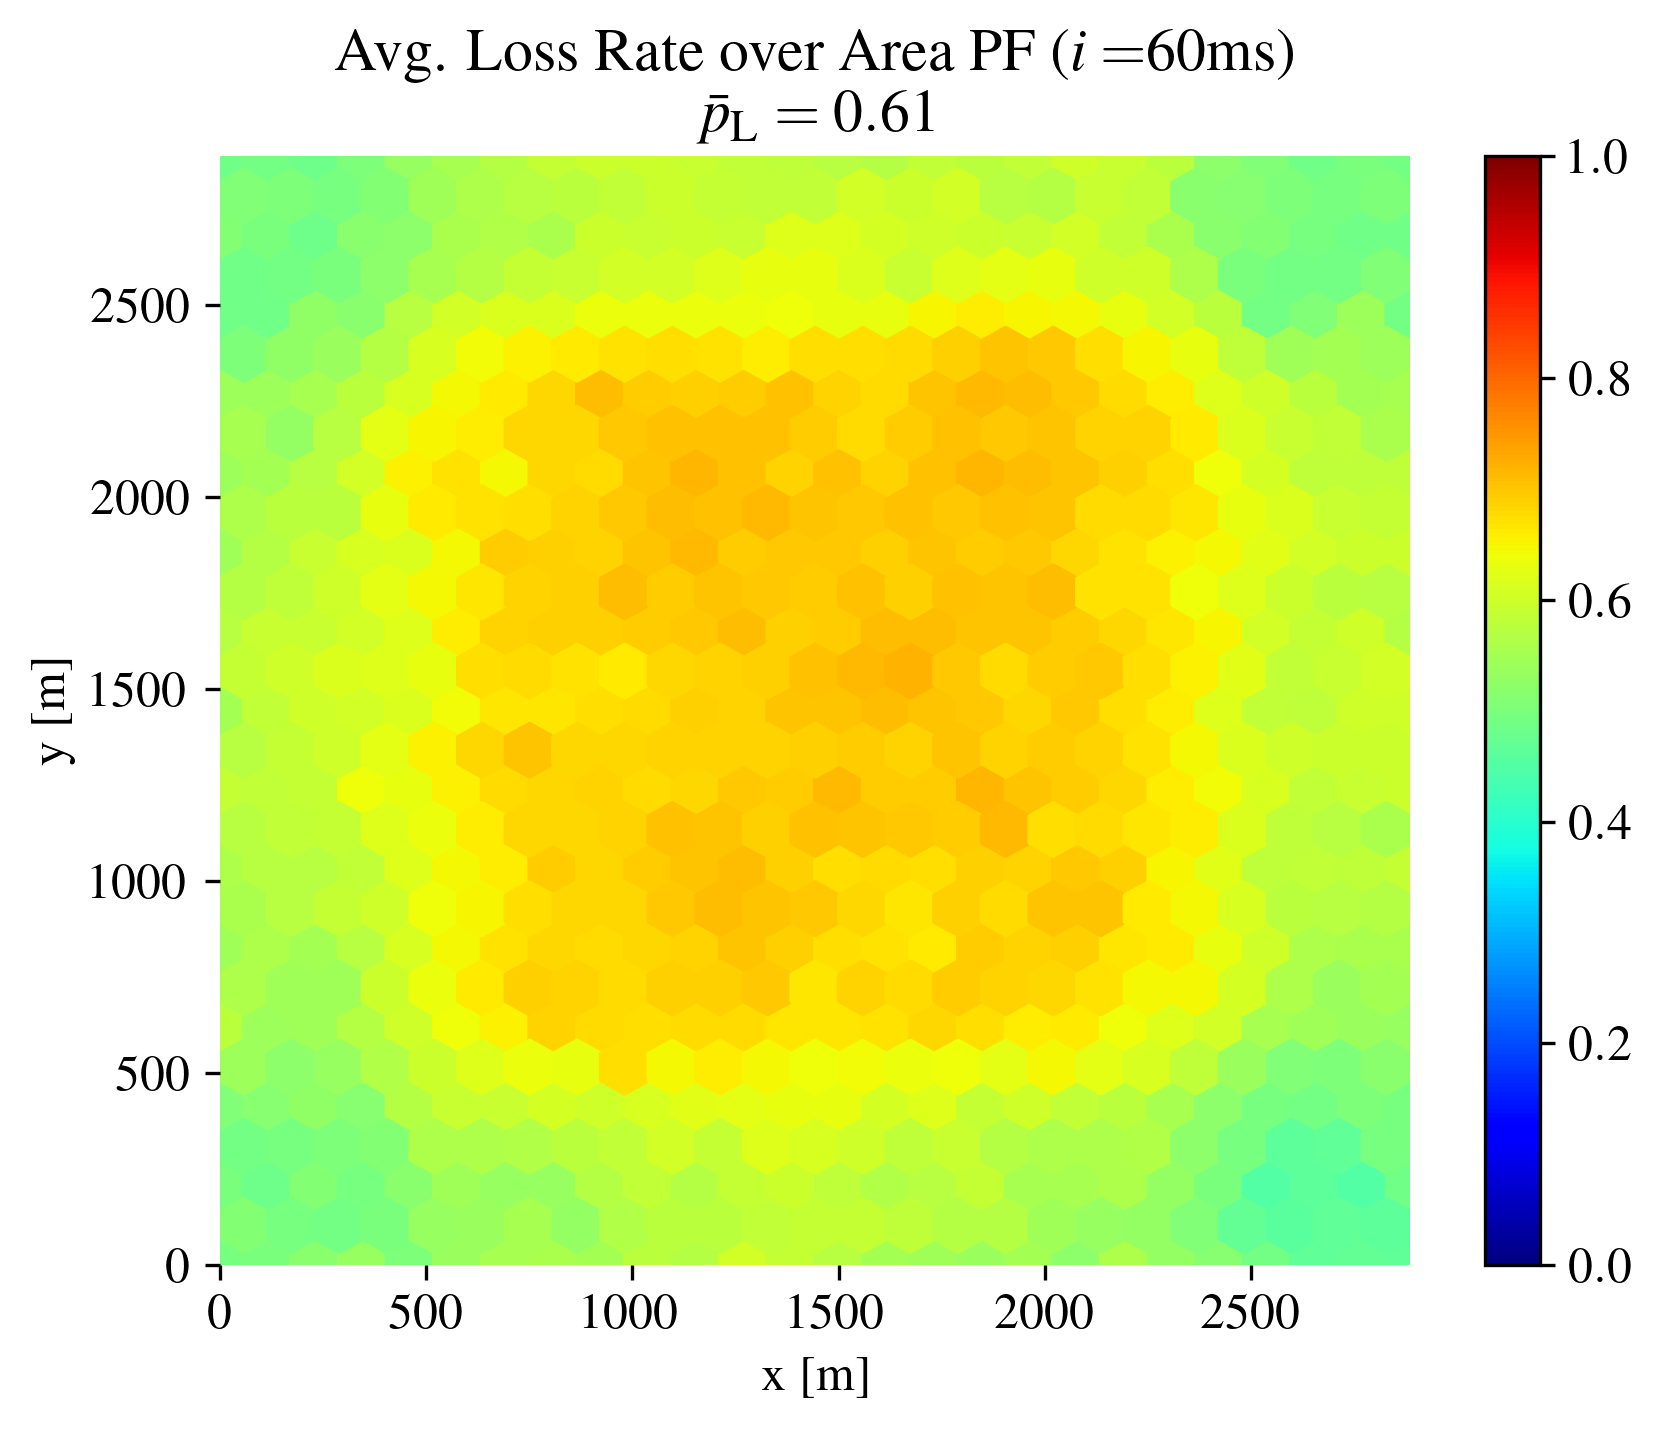

In [12]:
## PF
size = math.sqrt(n / 12) * 1000
fig, ax = plt.subplots()
im = ax.hexbin(
    pos_x_pf, 
    pos_y_pf, 
    C=1-reception_rates_pf, 
    vmin=0,
    vmax=1,
    gridsize=25,
    clip_on=True,
    cmap=cm.jet
)

#ax.axis(False)
ax.set_ylim([0,size])
ax.set_xlim([0,size])
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.title(f'Avg. Loss Rate over Area PF ($i=${i_pf}ms) \n$\\bar{{p}}_\\mathrm{{L}} = {1-np.mean(reception_rates_pf):.2f}$')
plt.colorbar(im)

fig.savefig(f"../figures/loss_rate_area_{config}_pf_n{n}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/loss_rate_area_{config}_pf_n{n}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

plt.show()